<a href="https://colab.research.google.com/github/22b1074/Vehicle-Detection-IE-643-/blob/main/SelfVision_IE643.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
# Create a directory for Kaggle datasets
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the appropriate directory
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d chrisviviers/cityscapes-leftimg8bit-trainvaltest   # My main dataset from cityscapes original and i got this to from kaggle

Dataset URL: https://www.kaggle.com/datasets/chrisviviers/cityscapes-leftimg8bit-trainvaltest
License(s): copyright-authors
100% 10.8G/10.8G [02:05<00:00, 100MB/s]
100% 10.8G/10.8G [02:05<00:00, 92.4MB/s]


In [ ]:
!kaggle datasets download -d ananthudupa2002/cityscapes-gtfine-trainvaltest   # Polygon labels Dataset with 3 image segments per image and 1 label file as .json file

Dataset URL: https://www.kaggle.com/datasets/ananthudupa2002/cityscapes-gtfine-trainvaltest
License(s): DbCL-1.0
 92% 221M/240M [00:02<00:00, 131MB/s]
100% 240M/240M [00:02<00:00, 94.9MB/s]


In [ ]:
import os

# Creating the required directory
os.makedirs('/content/input/cityscapes-leftimg8bit-trainvaltest/', exist_ok=True)


# Unzipping the dataset
!unzip /content/cityscapes-leftimg8bit-trainvaltest.zip -d /content/input/cityscapes-leftimg8bit-trainvaltest/

Streaming output truncated to the last 5000 lines.
  inflating: /content/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/test/berlin/berlin_000001_000019_leftImg8bit.png  
  inflating: /content/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/test/berlin/berlin_000002_000019_leftImg8bit.png  
  inflating: /content/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/test/berlin/berlin_000003_000019_leftImg8bit.png  
  inflating: /content/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/test/berlin/berlin_000004_000019_leftImg8bit.png  
  inflating: /content/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/test/berlin/berlin_000005_000019_leftImg8bit.png  
  inflating: /content/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/test/berlin/berlin_000006_000019_leftImg8bit.png  
  inflating: /content/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/test/berlin/berlin_000007_000019_leftImg8bit.png  
  inflating: /content/input/cityscapes-leftimg8bit-trainvalt

In [ ]:
!pip install torch torchvision opencv-python matplotlib albumentations

In [ ]:
# Clone the YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
# Install the needed dependencies
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Total 17022 (delta 0), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17022/17022), 15.61 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (11690/11690), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 17.9 MB/s eta 0:00:00


In [ ]:
%cd ..

/content


In [ ]:
!mkdir -p /content/input/gtfine_trainvaltest  # creating required dir

In [ ]:
!unzip /content/cityscapes-gtfine-trainvaltest.zip -d /content/input/gtfine_trainvaltest  #unzipping labels dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/input/gtfine_trainvaltest/gtFine/train/strasbourg/strasbourg_000001_051574_gtFine_instanceIds.png  
  inflating: /content/input/gtfine_trainvaltest/gtFine/train/strasbourg/strasbourg_000001_051574_gtFine_labelIds.png  
  inflating: /content/input/gtfine_trainvaltest/gtFine/train/strasbourg/strasbourg_000001_051574_gtFine_polygons.json  
  inflating: /content/input/gtfine_trainvaltest/gtFine/train/strasbourg/strasbourg_000001_051661_gtFine_color.png  
  inflating: /content/input/gtfine_trainvaltest/gtFine/train/strasbourg/strasbourg_000001_051661_gtFine_instanceIds.png  
  inflating: /content/input/gtfine_trainvaltest/gtFine/train/strasbourg/strasbourg_000001_051661_gtFine_labelIds.png  
  inflating: /content/input/gtfine_trainvaltest/gtFine/train/strasbourg/strasbourg_000001_051661_gtFine_polygons.json  
  inflating: /content/input/gtfine_trainvaltest/gtFine/train/strasbourg/strasbourg_000001_051877_gtFine_color.p

In [ ]:
os.makedirs('/content/working/labels_final', exist_ok=True)   # Moving all labels to 1 dir instead of original dirs structure as above like gtfine_trainvaltest/gtFine/(train,test,val)/city/label name as .json files

In [ ]:
import json
from pathlib import Path

# Vehicles classes used
classes_of_interest = {
    'bicycle': 0,
    'motorcycle': 1,
    'car': 2,
    'truck': 3,
    'bus': 4
}

def convert_cityscapes_to_yolo(gtfine_folder, leftimg8bit_folder, output_folder):
    # Ensuring the output folder exists
    Path(output_folder).mkdir(parents=True, exist_ok=True)

    # Iterating through each category folder (train, val, test)
    for split in ['train', 'val']:
        split_folder = os.path.join(gtfine_folder, split)
        print(split_folder)

        # Iterating over each city folder in the current split
        for city_folder in os.listdir(split_folder):
            city_path = os.path.join(split_folder, city_folder)

            # Checking if the current folder is actually a directory
            if os.path.isdir(city_path):
                # Iterating over each JSON file in the current city folder
                for json_file in os.listdir(city_path):
                    if json_file.endswith('.json'):
                        #print(f"Processing {json_file} in {city_path}")
                        with open(os.path.join(city_path, json_file), 'r') as f:
                            data = json.load(f)

                        # corresponding image name
                        image_name_base = json_file.replace('_gtFine_polygons.json', '')
                        image_name = f"{image_name_base}_leftImg8bit.png"  # images are in .png format

                        # Searching for the image in the corresponding city folder in leftImg8bit
                        image_folder_path = os.path.join(leftimg8bit_folder, split, city_folder)
                        image_path = os.path.join(image_folder_path, image_name)

                        if os.path.isfile(image_path):
                            #print(f"Image found: {image_path}")
                            bounding_boxes = []

                            # Iterating over objects in the JSON data to select only vehicle classes and converting polygon labels to yolo format with class id and bounding boxes
                            for obj in data['objects']:
                                category_name = obj['label']
                                if category_name in classes_of_interest:
                                    #print(f"Found object: {category_name}")

                                    # polygon vertices given
                                    polygon = obj['polygon']

                                    # bounding box calculation
                                    x_coords = [point[0] for point in polygon]
                                    y_coords = [point[1] for point in polygon]

                                    xmin = min(x_coords)
                                    xmax = max(x_coords)
                                    ymin = min(y_coords)
                                    ymax = max(y_coords)

                                    xmin = max(0, xmin)
                                    xmax = min(data['imgWidth'], xmax)
                                    ymin = max(0, ymin)
                                    ymax = min(data['imgHeight'], ymax)

                                    # center coordinates
                                    x_center = (xmin + xmax) / 2
                                    y_center = (ymin + ymax) / 2

                                    # width and height
                                    width = xmax - xmin
                                    height = ymax - ymin

                                    # Normalizing values
                                    image_width = data['imgWidth']
                                    image_height = data['imgHeight']
                                    x_center_normalized = x_center / image_width
                                    y_center_normalized = y_center / image_height
                                    width_normalized = width / image_width
                                    height_normalized = height / image_height

                                    # formatted bounding box (class_id, x_center, y_center, width, height)
                                    bounding_boxes.append(f"{classes_of_interest[category_name]} {x_center_normalized} {y_center_normalized} {width_normalized} {height_normalized}")

                            #print(f"Bounding boxes found: {len(bounding_boxes)}")

                            # Saving the bounding boxes to a txt file (same name as json)
                            if bounding_boxes:
                                output_file = os.path.splitext(json_file)[0] + '.txt'
                                with open(os.path.join(output_folder, output_file), 'w') as out_f:
                                    out_f.write("\n".join(bounding_boxes))
                                #print(f"Saved bounding boxes to {output_file}")
                            else:
                                print(f"No bounding boxes found for {json_file}")

# usage
gtfine_folder = '/content/input/gtfine_trainvaltest/gtFine'  # gtFine folder path
leftimg8bit_folder = '/content/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit'  # leftImg8bit folder path
output_folder = '/content/working/labels_final'  # output folder
convert_cityscapes_to_yolo(gtfine_folder, leftimg8bit_folder, output_folder)


/content/input/gtfine_trainvaltest/gtFine/train
No bounding boxes found for cologne_000108_000019_gtFine_polygons.json
No bounding boxes found for strasbourg_000000_007727_gtFine_polygons.json
No bounding boxes found for strasbourg_000000_016311_gtFine_polygons.json
No bounding boxes found for strasbourg_000000_018153_gtFine_polygons.json
No bounding boxes found for strasbourg_000001_061384_gtFine_polygons.json
No bounding boxes found for strasbourg_000001_016253_gtFine_polygons.json
No bounding boxes found for strasbourg_000001_007524_gtFine_polygons.json
No bounding boxes found for strasbourg_000000_012934_gtFine_polygons.json
No bounding boxes found for strasbourg_000001_004106_gtFine_polygons.json
No bounding boxes found for strasbourg_000000_016247_gtFine_polygons.json
No bounding boxes found for strasbourg_000000_035571_gtFine_polygons.json
No bounding boxes found for strasbourg_000001_001901_gtFine_polygons.json
No bounding boxes found for strasbourg_000001_003159_gtFine_polygon

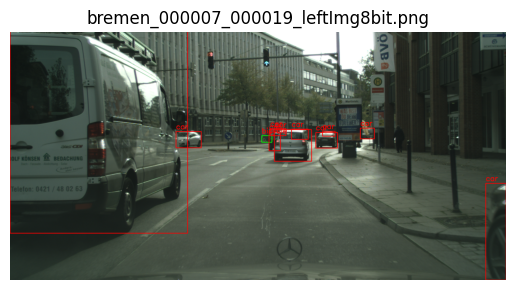

In [ ]:
# Visualization of IMages with Bounding boxes

import cv2
import matplotlib.pyplot as plt
classes_id_to_name = {
    0: 'bicycle',
    1: 'motorcycle',
    2: 'car',
    3: 'truck',
    4: 'bus'
}


def visualize_yolo_annotations(image_path, annotations_path):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    color_mapping = {
        0: (0, 255, 0),    # Green for bicycle
        1: (255, 0, 0),    # Blue for motorcycle
        2: (255, 0, 0),    # Red for car
        3: (238, 130, 238), # Violet for truck
        4: (255, 192, 203), # Pink for bus
    }

    # Check if the annotation file exists
    if os.path.isfile(annotations_path):
        # Read the annotations
        with open(annotations_path, 'r') as f:
            lines = f.readlines()

        # Process each annotation line
        for line in lines:
            # Split the line into components
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # the bounding box coordinates
            image_width = image.shape[1]
            image_height = image.shape[0]

            # Convert YOLO format to bounding box coordinates
            xmin = int((x_center - width / 2) * image_width)
            xmax = int((x_center + width / 2) * image_width)
            ymin = int((y_center - height / 2) * image_height)
            ymax = int((y_center + height / 2) * image_height)

            box_color = color_mapping.get(class_id, (255, 255, 255))  # Default to white if class_id is not found

            # Drawing the bounding box
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), box_color, 2)
            class_name = classes_id_to_name.get(class_id, "unkwown")
            cv2.putText(image, class_name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)

    # Display the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(os.path.basename(image_path))
    plt.show()

# usage
image_path = '/content/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/train/bremen/bremen_000007_000019_leftImg8bit.png'  # image path
annotations_path = '/content/working/labels_final/bremen_000007_000019_gtFine_polygons.txt'  # corresponding annotations path of above image
visualize_yolo_annotations(image_path, annotations_path)

In [ ]:
# creating dirs suitable for YOLO model
os.makedirs('/content/working/train/labels', exist_ok=True)
os.makedirs('/content/working/val/labels', exist_ok=True)
os.makedirs('/content/working/val/images', exist_ok=True)
os.makedirs('/content/working/train/images', exist_ok=True)
#os.makedirs('/content/working/test/images', exist_ok=True)
# used test images only before but chanegd to the images with cars > 8 as i used only images with cars <= 7, to balance the dataset

In [ ]:
# Before used Test images dataset
import os
import shutil
from pathlib import Path

# Define the test cities
test_cities = ['berlin', 'bielefeld', 'bonn', 'leverkusen', 'mainz', 'munich']
images_input_path = '/content/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/'
output_images_test_path = '/content/working/test/images'

for city in test_cities:
    city_image_folder_path = os.path.join(images_input_path, 'test', city)

    # Check if the city folder exists
    if os.path.isdir(city_image_folder_path):
        for image_file in os.listdir(city_image_folder_path):
            if image_file.endswith('_leftImg8bit.png'):
                # Move the image to the test output directory
                shutil.move(os.path.join(city_image_folder_path, image_file), output_images_test_path)
                print(f"Moved image {image_file} to {output_images_test_path}.")
    else:
        print(f"City folder for {city} not found.")

Moved image berlin_000521_000019_leftImg8bit.png to /content/working/test/images.
Moved image berlin_000541_000019_leftImg8bit.png to /content/working/test/images.
Moved image berlin_000055_000019_leftImg8bit.png to /content/working/test/images.
Moved image berlin_000538_000019_leftImg8bit.png to /content/working/test/images.
Moved image berlin_000487_000019_leftImg8bit.png to /content/working/test/images.
Moved image berlin_000456_000019_leftImg8bit.png to /content/working/test/images.
Moved image berlin_000276_000019_leftImg8bit.png to /content/working/test/images.
Moved image berlin_000428_000019_leftImg8bit.png to /content/working/test/images.
Moved image berlin_000190_000019_leftImg8bit.png to /content/working/test/images.
Moved image berlin_000506_000019_leftImg8bit.png to /content/working/test/images.
Moved image berlin_000306_000019_leftImg8bit.png to /content/working/test/images.
Moved image berlin_000472_000019_leftImg8bit.png to /content/working/test/images.
Moved image berl

In [ ]:
import shutil
validation_cities = ['munster', 'lindau', 'frankfurt']   # val cities in the val dir
images_input_path = '/content/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/'
labels_path = '/content/working/labels_final'
output_labels_train_path = '/content/working/train/labels'
output_labels_val_path = '/content/working/val/labels'
output_images_train_path = '/content/working/train/images'
output_images_val_path = '/content/working/val/images'
#output_images_test_path = '/content/working/test/images'

# output directories for labels and images
Path(output_labels_train_path).mkdir(parents=True, exist_ok=True)
Path(output_labels_val_path).mkdir(parents=True, exist_ok=True)
Path(output_images_train_path).mkdir(parents=True, exist_ok=True)
Path(output_images_val_path).mkdir(parents=True, exist_ok=True)
#Path(output_images_test_path).mkdir(parents=True, exist_ok=True)
# Iterate over each annotation file in the labels directory
for label_file in os.listdir(labels_path):
    if label_file.endswith('_gtFine_polygons.txt'):
        # Extract the base name and city information
        base_name = label_file.split('_gtFine_polygons.txt')[0]  # This is 'A'
        city_name = base_name.split('_')[0]  # Assuming 'A' is in the format 'a1_a2_a3', a1 is cityname

        # if this file is in validation
        if city_name.lower() in validation_cities:
            # validation file
            destination_label_path = output_labels_val_path
            destination_image_path = output_images_val_path
            images_input_path = os.path.join(images_input_path, 'val')
        # if this file is in train
        else:
            # training file
            destination_label_path = output_labels_train_path
            destination_image_path = output_images_train_path
            images_input_path = os.path.join(images_input_path, 'train')

        # corresponding image file name
        image_name = f"{base_name}_leftImg8bit.png"
        image_folder_path = os.path.join(images_input_path, base_name.split('_')[0])  # City folder for images
        image_path = os.path.join(image_folder_path, image_name)

        # Copy the corresponding image file if it exists along with its label file
        if os.path.isfile(image_path):
            shutil.copy(image_path, destination_image_path)
            shutil.copy(os.path.join(labels_path, label_file), destination_label_path)
            #print(f"Copied image {image_name} to {destination_image_path}.")
        else:
            print(f"Image {image_path} not found for label {label_file}.")
        images_input_path = '/content/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/'



In [ ]:
import os

# labels directory
labels_dir = '/content/working/train/labels' #REPLCAE TRAIN BY VAL ALSO

for label_file in os.listdir(labels_dir):
    if label_file.endswith('_gtFine_polygons.txt'):
        # Create the new label file name by removing '_gtFine_polygons'
        new_label_file = label_file.replace('_gtFine_polygons', '')  # Result will be 'A.txt'
        # Rename the file
        os.rename(os.path.join(labels_dir, label_file), os.path.join(labels_dir, new_label_file))
        #print(f'Renamed: {label_file} to {new_label_file}')

In [ ]:
import os

# images directory
labels_dir = '/content/working/train/images'

# Loop through each image file in the directory
for label_file in os.listdir(labels_dir):
    if label_file.endswith('_leftImg8bit.png'):
        # Create the new image file name by removing '_leftImg8bit'
        new_label_file = label_file.replace('_leftImg8bit', '')  # Result will be 'A.png'
        # Rename the file
        os.rename(os.path.join(labels_dir, label_file), os.path.join(labels_dir, new_label_file))
        #print(f'Renamed: {label_file} to {new_label_file}')

In [ ]:
# Here i am copying images with some conditions on no.of classes of vehicle classes for finding some balanced classes dataset and suitable test dataset to have similar no.of instances for val dataset and test dataset


import shutil
import numpy as np
labels_here_dir = '/content/working/train/labels'
images_here_dir = '/content/working/train/images'
target_images_dir = '/content/working/filtered_train_normaltest/images/8cars11'
target_labels_dir = '/content/working/filtered_train_normaltest/labels/8cars11'
os.makedirs(target_images_dir, exist_ok=True)
os.makedirs(target_labels_dir, exist_ok=True)
count_removed = 0
car_class_id = 2
bicycle_class_id = 0
motorcycle_class_id = 1
truck_class_id = 3
bus_class_id = 4
for label_file in os.listdir(labels_here_dir):
    labels_path = os.path.join(labels_here_dir, label_file)
    # Read the label file and check for the presence of cars
    with open(labels_path, 'r') as f:
        labels = f.readlines()

    # Count the number of car instances in the label file
    num_cars = sum(1 for label in labels if int(label.split()[0]) == car_class_id)
    num_bicycles = sum(1 for label in labels if int(label.split()[0]) == bicycle_class_id)
    num_buses = sum(1 for label in labels if int(label.split()[0]) == bus_class_id)
    num_trucks = sum(1 for label in labels if int(label.split()[0]) == truck_class_id)
    num_motorcycles = sum(1 for label in labels if int(label.split()[0]) == motorcycle_class_id)

    if 7<num_cars<11:
        #os.remove(labels_path)
        image_file = label_file.replace('.txt', '.png')
        image_path = os.path.join(images_here_dir, image_file)
        if os.path.exists(image_path):
            shutil.copy(image_path, target_images_dir)
            shutil.copy(labels_path, target_labels_dir)

            #os.remove(image_path)
            #os.remove(labels_path)
            count_removed += 1


# Print the count of removed/copied images and labels
print(f"Removed/Copied {count_removed} ")

Removed 490 images and labels containing 8 or more cars.


In [ ]:
# this is to check no.of classes in a particular dataset selected
import os

# label files
label_dir = '/content/working/train/labels'  # change path as needed

class_counts = {label: 0 for label in classes_of_interest.keys()}

# Iterate over all label files
for label_file in os.listdir('/content/working/filtered_raintest/labels/set8'):
    if label_file.endswith('.txt'):  # Ensure it's a label file
        with open(os.path.join(label_dir, label_file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])  # class id extraction
                for class_name, id in classes_of_interest.items():
                    if class_id == id:
                        class_counts[class_name] += 1

# Print the number of images in each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} instances")

total_instances = sum(class_counts.values())
num_classes = 5
#class_weights = {class_name: total_instances / (num_classes * count) for class_name, count in class_counts.items()}
#print(class_weights)
# use class weights when no class is set to zero in the dataset we are checking

bicycle: 34 instances
motorcycle: 14 instances
car: 88 instances
truck: 2 instances
bus: 9 instances


In [ ]:
class_weights_here = [0.5846461615403851, 3.0885072655217964, 0.3684791174152876, 9.823529411764707, 6.660968660968661]  #used class_weigths in loss function to deal with imbalanced classes dataset

In [ ]:
#used images with no.of car classes in the range 7 < cars < 11
source_dir = '/content/working/filtered_train/labels/carsgt7ls11'
destination_dir = '/content/drive/MyDrive/NormalWeather_IE643/test/labels'
os.makedirs(destination_dir, exist_ok=True)
label_files = os.listdir(source_dir)
for filename in label_files:
    if filename.endswith('.txt'):
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)
        shutil.move(source_path, destination_path)

In [ ]:
!rm -r /content/drive/MyDrive/NormalWeather_IE643/test  #used to remove previous test dataset in normal weather , but by mistakenly reomved just folder so the images came to NormalWeather_IE643 folder and created new ones in test

no.of images with cars=1 is 167

In [ ]:
# copied test labels of Normal weather dataset to drive to use later
source_dir = target_labels_dir
destination_dir = '/content/drive/MyDrive/NormalWeather_IE643/test/labels'
os.makedirs(destination_dir, exist_ok=True)
for filename in label_files:
    if filename.endswith('.txt'):
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)
        shutil.copy(source_path, destination_path)

In [ ]:
# For augmentations i used albumentations finally, at start used ImageDataGenerator but it didn't chaneg labels accordingly so used albumentations
import albumentations as A
from keras.preprocessing.image import img_to_array, load_img


# augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(-45,45),p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(p=0.3),
    A.Blur(blur_limit=3, p=0.2),
],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
import cv2
def load_bboxes(label_file_path):
    bboxes = []
    class_labels = []
    with open(label_file_path, 'r') as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            bboxes.append([x_center, y_center, width, height])  # YOLO format
            class_labels.append(int(class_id))  # Store the class id separately
    return bboxes, class_labels

def save_bboxes(output_label_path, bboxes, class_labels):
    with open(output_label_path, 'w') as file:
        for bbox, class_id in zip(bboxes, class_labels):
            x_center, y_center, width, height = bbox
            file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")
def augment_single_image(image_path, label_file_path, output_image_dir, output_label_dir, num_augments=5):
    # Load the image and bounding boxes
    image = cv2.imread(image_path)
    bboxes, class_labels = load_bboxes(label_file_path)

    # augmentations performed
    for i in range(num_augments):
        # Applied augmentations
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_class_labels = augmented['class_labels']

        # Naming augmented files with 'aug_{num}' to identify its augmented
        image_name = os.path.basename(image_path)
        output_image_path = os.path.join(output_image_dir, f"{image_name.replace('.png', f'_aug_{i}.png')}")
        output_label_path = os.path.join(output_label_dir, f"{image_name.replace('.png', f'_aug_{i}.txt')}")

        # augmented image
        cv2.imwrite(output_image_path, aug_image)

        # Save the corresponding labels with updated bounding boxes
        save_bboxes(output_label_path, aug_bboxes, aug_class_labels)

97 images have 0 cars and in those i have 214 bicycles, 37 motorcycles, 4 trucks and 16 buses

2) 167 umages have cars in those i have 214 bicycles, 36 motorcycles, 167 cars, 10 trucks, 17 buses

3) 187 images have 2 cars and in those i have 258 cycles, 35 motorcycles, 24 trucks, 28 buses

I have 211 images with 211 buses (1 in each), 44 trucks, 1754 cars, 55motorcycles, 255 bicycles

I have 43 images with 2 buses and those have 381 cars, 93 bicycles, 2 trucks, 12 motorcycles


I have 279 images with 1 truck each and in thsoe i have 338 cycles, 83 bikes, 2854 cars, 42 buses

In [ ]:
!pip install keras tensorflow

In [ ]:
# the previously used ImageDataGenerator for augmentations ,did not work for automatic label changing so changed to use albumentations
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
nocar_images_dir = '/content/working/filtered_train/images/nocar'
augmented_nocar_images_dir = '/content/working/augmented_nocar/images'
augmented_nocar_labels_dir = '/content/working/augmented_nocar/labels'
os.makedirs(augmented_nocar_images_dir, exist_ok=True)
os.makedirs(augmented_nocar_labels_dir, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to adjust bounding boxes based on transformations
def adjust_bounding_boxes(bboxes, image_shape, rotation_angle=0, shift_x=0, shift_y=0, shear=0, horizontal_flip=False):
    adjusted_bboxes = []
    image_width, image_height = image_shape[1], image_shape[0]

    for class_id, xmin, ymin, xmax, ymax in bboxes:
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        width = xmax - xmin
        height = ymax - ymin

        # Apply shifts
        x_center += shift_x
        y_center += shift_y

        # Apply horizontal flip
        if horizontal_flip:
            x_center = image_width - x_center

        # Create rotation matrix
        if rotation_angle != 0:
            # Convert to radians
            angle_rad = np.radians(rotation_angle)
            # Calculate rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D((image_width / 2, image_height / 2), rotation_angle, 1.0)

            # Get the new bounding box corners after rotation
            corners = np.array([
                [xmin, ymin],
                [xmax, ymin],
                [xmax, ymax],
                [xmin, ymax]
            ])
            rotated_corners = cv2.transform(corners.reshape(-1, 1, 2), rotation_matrix).reshape(-1, 2)

            # Get new xmin, xmax, ymin, ymax from rotated corners
            xmin, ymin = rotated_corners[:, 0].min(), rotated_corners[:, 1].min()
            xmax, ymax = rotated_corners[:, 0].max(), rotated_corners[:, 1].max()

        # Apply shear transformation if needed
        if shear != 0:
            # This is a simple shear matrix applied for horizontal shear
            shear_matrix = np.array([[1, np.tan(np.radians(shear))],
                                      [0, 1]])
            corners = np.array([
                [xmin, ymin],
                [xmax, ymin],
                [xmax, ymax],
                [xmin, ymax]
            ])
            sheared_corners = np.dot(corners, shear_matrix.T)

            xmin, ymin = sheared_corners[:, 0].min(), sheared_corners[:, 1].min()
            xmax, ymax = sheared_corners[:, 0].max(), sheared_corners[:, 1].max()

        # Normalize back to YOLO format
        adjusted_bboxes.append(
            f"{class_id} {(x_center) / image_width} {(y_center) / image_height} {(xmax - xmin) / image_width} {(ymax - ymin) / image_height}"
        )

    return adjusted_bboxes

In [ ]:
# Function to get the last saved image in the directory
def get_last_saved_image(directory):
    files = os.listdir(directory)
    files = [f for f in files if f.endswith('.png')]  # Filter for PNG files
    if not files:
        return None
    return max(files, key=lambda x: os.path.getctime(os.path.join(directory, x)))  # Get the latest file by creation time

#used this for naming label file based on augmented image ,in augmentations of ImageDataGenerator

In [ ]:
get_last_saved_image('/content/working/train/images')

'image1854.png'

In [ ]:
nocar_images_dir = '/content/working/filtered_train/images/1truck'  #change to dir need to augment
# used 20 augments per image with images of 1 bus and <x cars (used x accordingly)

In [ ]:
for img_file in os.listdir(nocar_images_dir):
    img_path = os.path.join(nocar_images_dir, img_file)

    # Load image
    img = load_img(img_path)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for the generator

    # Get the corresponding label file
    label_file = img_file.replace('.png', '.txt')
    label_path = os.path.join(nocar_images_dir.replace('images', 'labels'), label_file)

    if os.path.exists(label_path):
        # Read the original bounding boxes
        with open(label_path, 'r') as f:
            lines = f.readlines()

        # Extract bounding boxes
        bboxes = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1]) * img.width
            y_center = float(parts[2]) * img.height
            width = float(parts[3]) * img.width
            height = float(parts[4]) * img.height

            xmin = x_center - (width / 2)
            xmax = x_center + (width / 2)
            ymin = y_center - (height / 2)
            ymax = y_center + (height / 2)

            bboxes.append((class_id, xmin, ymin, xmax, ymax))

        # Generate augmented images and save adjusted bounding boxes
        for i, batch in enumerate(datagen.flow(img_array, batch_size=10, save_to_dir=augmented_nocar_images_dir,
                                  save_prefix='aug', save_format='png')):
            last_image = get_last_saved_image(augmented_nocar_images_dir)
            # Get transformation parameters
            rotation_angle = np.random.uniform(-30, 30)  # Random angle for rotation
            shift_x = np.random.uniform(-0.2 * img.width, 0.2 * img.width)  # Random horizontal shift
            shift_y = np.random.uniform(-0.2 * img.height, 0.2 * img.height)  # Random vertical shift
            shear = np.random.uniform(-20, 20)  # Random shear angle

            # Adjust bounding boxes
            adjusted_labels = adjust_bounding_boxes(bboxes, img_array[0].shape,
                                                     rotation_angle=rotation_angle,
                                                     shift_x=shift_x,
                                                     shift_y=shift_y,
                                                     shear=shear,
                                                     horizontal_flip=True)  # Pass dynamic parameters

            # Save the adjusted bounding boxes
            new_label_file = last_image.replace('.png', '.txt')
            new_label_path = os.path.join(augmented_nocar_labels_dir, new_label_file)
            with open(new_label_path, 'w') as f:
                for bbox in adjusted_labels:
                    f.write(bbox + '\n')

            # Create new image name
            #base_name = img_file.replace('.png', '')  # Use the original image name as base
            #new_img_file = f"{base_name}_aug_{i}.png"  # Create image name as basename_aug_{i}.png

            # Rename the saved augmented image to the desired format
            #os.rename(augmented_image_file, os.path.join(augmented_nocar_images_dir, new_img_file))

            if i >= 19:  # Stop after generating 10 augmentations
                break

In [ ]:
source_dir = augmented_nocar_labels_dir  # augmented labels saved here for ImageDataGenerator
destination_dir = '/content/working/train/labels'
label_files = os.listdir(source_dir)
for i,filename in enumerate(label_files, start=1855):
    if filename.endswith('.txt'):
        new_filename = f"image{i}.txt"
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, new_filename)
        shutil.move(source_path, destination_path)

In [ ]:
source_dir = augmented_nocar_images_dir
destination_dir = '/content/working/train/images'
label_files = os.listdir(source_dir)
for i,filename in enumerate(label_files, start=1855):
    if filename.endswith('.png'):
        new_filename = f"image{i}.png"
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, new_filename)
        shutil.move(source_path, destination_path)

In [ ]:
# Path to the train.py file
train_py_path = '/content/yolov5/classify/train.py'

# Read the file
with open(train_py_path, 'r') as file:
    lines = file.readlines()

# Print the 190th to 200th lines to check the context
for i in range(190, 200):
    print(f"{i+1}: {lines[i]}")

# Prepare the new criterion line with class weights
new_criterion_line = f"    criterion = smartCrossEntropyLoss(label_smoothing=opt.label_smoothing, class_weights={class_weights_here})  # loss function\n"

lines[198] = new_criterion_line

with open(train_py_path, 'w') as file:
    file.writelines(lines)



191:     ema = ModelEMA(model) if RANK in {-1, 0} else None

192: 

193:     # DDP mode

194:     if cuda and RANK != -1:

195:         model = smart_DDP(model)

196: 

197:     # Train

198:     t0 = time.time()

199:     criterion = smartCrossEntropyLoss(label_smoothing=opt.label_smoothing)  # loss function

200:     best_fitness = 0.0



In [ ]:
# Read the file
with open(train_py_path, 'r') as file:
    lines = file.readlines()

# Print the 190th to 200th lines to check
for i in range(190, 200):
    print(f"{i+1}: {lines[i]}")

191:     ema = ModelEMA(model) if RANK in {-1, 0} else None

192: 

193:     # DDP mode

194:     if cuda and RANK != -1:

195:         model = smart_DDP(model)

196: 

197:     # Train

198:     t0 = time.time()

199:     criterion = smartCrossEntropyLoss(label_smoothing=opt.label_smoothing, class_weights=[0.5846461615403851, 3.0885072655217964, 0.3684791174152876, 9.823529411764707, 6.660968660968661])  # loss function

200:     best_fitness = 0.0



In [ ]:
!cat /content/working/data.yaml


train: /content/working/train/images1
val: /content/working/val/images1

nc: 5  # Number of classes
names: ['bicycle', 'motorcycle', 'car', 'truck', 'bus']  # Class names


In [ ]:
# mounting g-drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/yolov5/models


common.py	 hub	      segment  yolo.py	     yolov5m.yaml  yolov5s.yaml
experimental.py  __init__.py  tf.py    yolov5l.yaml  yolov5n.yaml  yolov5x.yaml


In [ ]:
# Path to the yolov5m.yaml file
yaml_path = "/content/yolov5/models/yolov5m.yaml"

# Open the file, read contents, and modify 'nc' to 5
with open(yaml_path, 'r') as file:
    lines = file.readlines()

# Rewrite the file with updated nc
with open(yaml_path, 'w') as file:
    for line in lines:
        if line.strip().startswith('nc:'):
            file.write('nc: 5\n')  # Updating to 5 classes from 80classes in yolo5vm.yaml
        else:
            file.write(line)

print("Updated yolov5m.yaml with nc=5.")


Updated yolov5m.yaml with nc=5.


In [ ]:
!cat /content/yolov5/models/yolov5m.yaml


# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 5
depth_multiple: 0.67 # model depth multiple
width_multiple: 0.75 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # c

In [ ]:
# paths and class names
train_images_path = '/content/working/train/images'  # Path to  training images
train_labels_path = '/content/working/train/labels'  # Path to  training labels
val_images_path = '/content/working/val/images'      # Path to  validation images
val_labels_path = '/content/working/val/labels'      # Path to  validation labels

#  class names
class_names = ['bicycle', 'motorcycle', 'car', 'truck', 'bus']

# Create the data.yaml file
data_yaml_content = f"""
train: {train_images_path}
val: {val_images_path}

nc: {len(class_names)}  # Number of classes
names: {class_names}  # Class names
"""

# Write to data.yaml file
with open('/content/working/data.yaml', 'w') as f:
    f.write(data_yaml_content)

print("data.yaml file created successfully!")


data.yaml file created successfully!


In [ ]:
%cd ..


/content


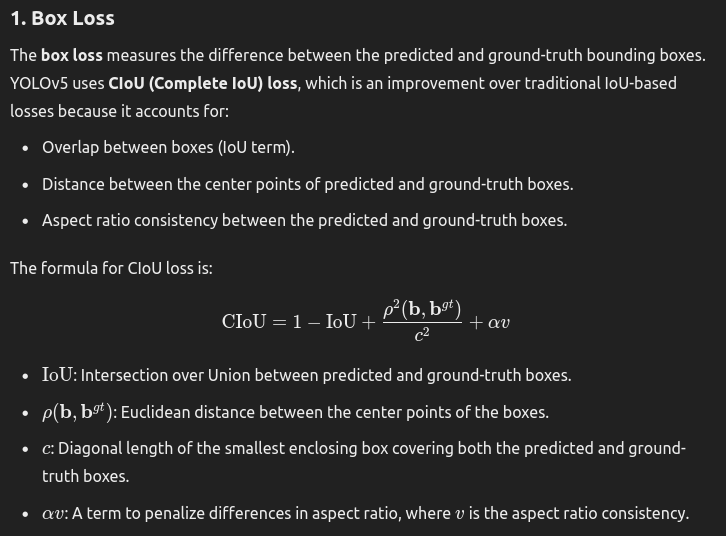

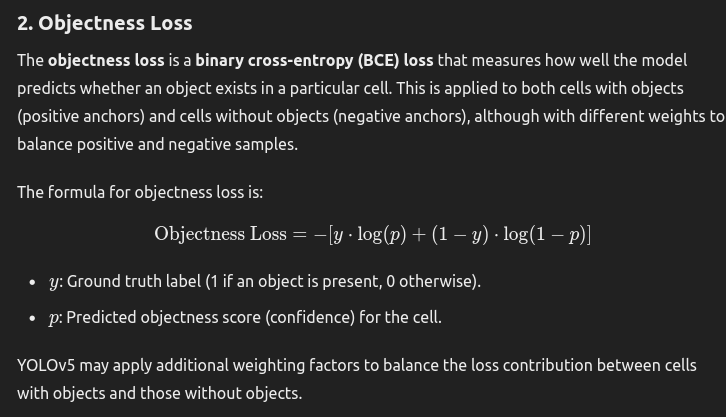

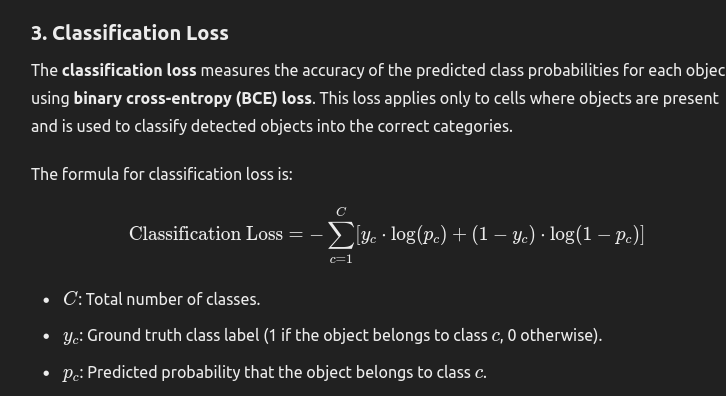

In [ ]:
%cd yolov5

/content/yolov5


In [ ]:

!python train.py --img 640 --batch-size 8 --epochs 50 --data /content/working/data.yaml --cfg yolov5m.yaml --weights yolov5m.pt --name yolov5_custom --project '/content/drive/MyDrive/yolov5_training'

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: preethic749 (preethic749-iit-bombay). Use `wandb login --relogin` to force relogin
train: weights=yolov5m.pt, cfg=yolov5m.yaml, data=/content/working/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=Fal

In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('yolov8m.pt')  # Change this to your specific model if needed

# Print model configuration
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_

In [ ]:
# used this to have test dataset for fog from Albumentations
fog_augment = A.Compose([
    A.RandomFog(
        fog_coef_lower=0.5,  # Minimum fog coefficient
        fog_coef_upper=0.9,  # Maximum fog coefficient
        alpha_coef=0.1,      # Controls the color of the fog
        beta=random.uniform(0.01, 0.02),
        p=1.0                 # Probability of applying fog
    )
])

<ipython-input-118-2d0680b4d21f>:2: UserWarning: Argument 'beta' is not valid and will be ignored.
  A.RandomFog(


In [ ]:
# Rain augmentation function to a image using Albumentations
rain_augment = A.Compose([
    A.RandomRain(
        brightness_coefficient=random.uniform(0.5,0.8),  # custom function for randomness
        drop_length=random.randint(15, 20),              # Random length between 15 and 20
        drop_width=random.randint(1, 2),                 # Random width
        blur_value=random.randint(1, 3),                  # Random blur value
        p=1.0                                             # Probability of applying rain
    )
])

In [ ]:
def augment_rainy_images(input_image_dir, output_image_dir):
    os.makedirs(output_image_dir, exist_ok=True)

    image_files = os.listdir(input_image_dir)

    for image_name in image_files:
        image_path = os.path.join(input_image_dir, image_name)
        image = cv2.imread(image_path)

        if image is not None:

            augmented = rain_augment(image=image)
            rainy_image = augmented['image']

            # Save the foggy image
            output_image_path = os.path.join(output_image_dir, image_name)
            cv2.imwrite(output_image_path, rainy_image)

In [ ]:
input_image_dir = '/content/working/filtered_raintest/images/set8'  # change dir accordingly
output_image_dir = '/content/drive/MyDrive/RainyFinal_IE643/test/images' # change dir accordingly
augment_rainy_images(input_image_dir, output_image_dir)

In [ ]:
def augment_foggy_images(input_image_dir, output_image_dir):
    os.makedirs(output_image_dir, exist_ok=True)

    image_files = os.listdir(input_image_dir)

    for image_name in image_files:
        image_path = os.path.join(input_image_dir, image_name)
        image = cv2.imread(image_path)

        if image is not None:
            augmented = fog_augment(image=image)
            foggy_image = augmented['image']

            # Save the foggy image
            output_image_path = os.path.join(output_image_dir, image_name)
            cv2.imwrite(output_image_path, foggy_image)

In [ ]:
input_image_dir = '/content/working/filtered_train_foggytest/images/set2'  # change dir accordingly
output_image_dir = '/content/foggy_augs_test/images'  # change dir accordingly
augment_foggy_images(input_image_dir, output_image_dir)

In [ ]:
# check how it works for foggy simulation on image
import random
def augment_single_foggy_image(input_image_path, output_image_path):
    # Load the image
    image = cv2.imread(input_image_path)
    os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
    if image is not None:

        augmented = fog_augment(image=image)
        foggy_image = augmented['image']

        # Save the foggy image
        cv2.imwrite(output_image_path, foggy_image)
        print(f"Foggy image saved to: {output_image_path}")
    else:
        print(f"Error: Could not read image from {input_image_path}")

In [ ]:
input_image_path = '/content/working/filtered_train_foggytest/images/set2/aachen_000014_000019.png'
output_image_path = '/content/foggy_aug_image1/image5.png'
augment_single_foggy_image(input_image_path, output_image_path)

Foggy image saved to: /content/foggy_aug_image1/image5.png


In [ ]:
import os
source_dir = '/content/working/filtered_raintest/labels/set8'
dest_dir = '/content/drive/MyDrive/RainyFinal_IE643/test/labels'
os.makedirs(dest_dir, exist_ok=True)
filenames = os.listdir(source_dir)
for filename in filenames:
    if filename.endswith('.txt'):
        source_path = os.path.join(source_dir, filename)
        #new_filename = filename.replace('.txt', '_foggy.txt')  #change accorcingly
        dest_path = os.path.join(dest_dir, filename)
        shutil.move(source_path, dest_path)